<a href="https://colab.research.google.com/github/marcosfs2006/fundos_investimentos/blob/master/Analise_Fundos_Investimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----

# **FUNDOS DE INVESTIMENTOS**

----
Para garantir que os RPPS tenham recursos acumulados para pagar os benefícios (aposentadorias e pensões) a seus beneficiários eles possuem uma carteira de ativos, chamados de ativos garantidores, dos quais os **fundos de investimentos** são os mais expressivos. 

Para quem quiser saber mais sobre fundos de investimenos recomendo o documento denominado [**Fundos de Investimentos para RPPS – CVM – CADERNO 10**](http://sa.previdencia.gov.br/site/2016/08/CVM-Caderno-10semISBNparaimpressao.pdf).

Neste documento utilizamos alguns conjuntos de dados. A relação de fundos de investimentos será obtida a partir da base e dados do DAIR disponibilizados pela SPrev em seu [site de dados abertos](http://www.previdencia.gov.br/dados-abertos/estatisticas-e-informacoes-dos-rpps/).

Os dados disponíveis são relativos à atualização de ABR de 2020. O arquivo do DRAA importado é o seguinte:

* `Carteira 2013_a_2020_Atualizacao_de_abr_2020_extração_em_18.05.20202020-05-18.csv`   

Para conhecer um pouco mais sobre fundos de investimentos, consulte a página http://www.cvm.gov.br/menu/regulados/fundos/sobre.html

<br>
<br>

---

# **PARTE I - CONSTRUÇÃO DE UMA BASE DADOS DE FUNDOS DE INVESTIMENTOS**

---

<br>

Nesta parte do notebook o objetivo é construir uma base de dados de fundos de investimentos nos quais existam investimentos de RPPS. A relação dos fundos será retirada da base de dados do DAIR. 

In [0]:
# Anexar o repositório do GitHub contendo os dados...
system('git clone https://github.com/marcosfs2006/fundos_investimentos.git')
setwd("/content/fundos_investimentos")

In [0]:
install.packages("plotly")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘hexbin’, ‘data.table’




In [0]:
# Carregar os pacotes necessários...
options(scipen = 999, message = FALSE)
library(readr)
library(dplyr)
library(ggplot2)
library(stringr)
library(readxl)
library(lubridate)
library(purrr)
library(plotly)


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [0]:
# Importar os dados do DAIR...

dair  <- readRDS("dair_DtRef_ABR2020.Rds") %>% 
              mutate(enquad_rpps_pad = str_extract(tipo_ativo, "Art.*$"),
                     enquad_rpps_pad = toupper(gsub("[[:punct:]]| |º", "", enquad_rpps_pad))) 

glimpse(dair)

Rows: 942,343
Columns: 16
$ cnpj               <chr> "63606479000124", "63606479000124", "6360647900012…
$ uf                 <chr> "AC", "AC", "AC", "AC", "AC", "AC", "AC", "AC", "A…
$ ente               <chr> "Governo do Estado do Acre", "Governo do Estado do…
$ competencia        <date> 2018-01-01, 2018-01-01, 2018-01-01, 2018-01-01, 2…
$ segmento           <chr> "Disponibilidades Financeiras", "Disponibilidades …
$ tipo_ativo         <chr> "Disp", "Disp", "Disp", "Disp", "FI 100% títulos T…
$ limite_resol_cmn   <dbl> NA, NA, NA, NA, 99.99, NA, NA, 100.00, NA, NA, NA,…
$ ident_ativo        <chr> "2358  61786", "3550  83615", "3550  5738X", "3550…
$ nm_ativo           <chr> " 1 Banco do Brasil S.A.", " 1 Banco do Brasil S.A…
$ qtd_quotas         <dbl> 1.0, 1.0, 1.0, 1.0, 252362.9, 1.0, 1.0, 8266289.1,…
$ vlr_atual_ativo    <dbl> 0.000000, 0.000000, 14391809.910000, 0.000000, 2.3…
$ vlr_total_atual    <dbl> 0.0, 0.0, 14391809.9, 0.0, 588068.6, 0.0, 12988.7,…
$ perc_recursos_rpps <dbl>

A base do DAIR contem todos os ativos nos quais o cada RPPS aplica seus recursos.

Vamos explicitar o significado de cada variável:

Variável    |  Descrição
------------|--------------------------------------------
`cnpj`      | CNPJ do ente federativo
`uf`        | sigla da unidade da federação
`ente`      | nome do ente
`competencia`| mês e ano de competência do DAIR. o dia é sempre o dia 1o.
`segmento` | segmento a que pertence o ativo
`tipo_ativo`| tipo de ativo no qual o RPPS investiu
limite_resol_cmn` | percentual máximo de seus recursos que o RPPS pode investir no tipo de ativo em referência
`ident_ativo`     | identificação do ativo. 
`nm_ativo`        | nome do ativo
`qtd_quotas`      | quantidade de cotas do ativo que o RPPS possui
`vlr_atual_ativo` |valor da unitário do ativo
`vlr_total_atual` |valor total do ativo que o RPPS possui
`perc_recursos_rpps` |percentual dos recursos do RPPS que o ativo representa
`pl_fundo`           |patrimônio líquido do fundo de investimento
`perc_pl_fundo`   | percentual do património líquido do fundo que o valor investido pelo RPPS representa
`enquad_rpps_pad` |enquadramento do fundo de investimentos realizado pelo RPPS.




Vamos dar uma olhada em quais segmentos os RPPS posem aplicar seus recursos:

In [0]:
dair %>%
  distinct(segmento)

segmento
<chr>
Disponibilidades Financeiras
Renda Fixa
Renda Vari?vel e Investimentos Estruturados
Investimentos no Exterior
"Demais Bens, Direitos e Ativos"
Imóveis
Aplicações Vedadas em Resolução CMN


Agora vamos dar uma olhada nos tipos de ativos:

In [0]:
dair %>%
  filter(competencia >= dmy("01042018")) %>%
  distinct(tipo_ativo)

tipo_ativo
<chr>
Disp
"FI 100% títulos TN - Art. 7º, I, b"
"FI Multimercado - Aberto - Art. 8º, III"
"FI de Ações - Índices c/ no mínimo 50 ações - Art. 8º, I, a"
"FI Imobiliários - Art. 8º, IV, b"
"FI Renda Fixa - Geral - Art. 7º, IV, a"
"FI de Ações - Geral - Art. 8º, II, a"
"FI Renda Fixa ""Crédito Privado"" - Art. 7º, VII, b"
"FI Renda Fixa ""Referenciado"" - Art. 7º, III, a"


### **Base de Fundos de Investimentos**

Para o nosso estudo, apenas os fundos de investimento são de interesse. Os demais ativos nos quais o RPPS possui recursos aplicados não serão utilizados.

 No código a seguir vamos aplicar um filtro a essa base de dados de forma a só ficarmos com os fundos de investimentos.

In [0]:
# filtrar a base para pegar apenas os registros cujos ativos sejam fundos de investimentos
dair_fundos <- dair %>% 
              filter(competencia >= as.Date("2018-04-01"),  # Pega dados posteriores a Abr/2018
                     grepl("\\d{14}", ident_ativo))         # Pega só fundos

glimpse(dair_fundos)

Rows: 569,428
Columns: 16
$ cnpj               <chr> "63606479000124", "63606479000124", "6360647900012…
$ uf                 <chr> "AC", "AC", "AC", "AC", "AC", "AC", "AC", "AC", "A…
$ ente               <chr> "Governo do Estado do Acre", "Governo do Estado do…
$ competencia        <date> 2019-01-01, 2020-01-01, 2020-01-01, 2019-02-01, 2…
$ segmento           <chr> "Renda Fixa", "Renda Fixa", "Renda Fixa", "Renda F…
$ tipo_ativo         <chr> "FI 100% títulos TN - Art. 7º, I, b", "FI 100% tít…
$ limite_resol_cmn   <dbl> 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, …
$ ident_ativo        <chr> "11328882000135", "11328882000135", "1307741500010…
$ nm_ativo           <chr> " BB PREVIDENCIÁRIO RENDA FIXA IRF M1", " BB PREVI…
$ qtd_quotas         <dbl> 8266289.1, 8266289.1, 5708220.8, 8266289.1, 216786…
$ vlr_atual_ativo    <dbl> 2.487444, NA, 2.086017, 0.000000, 2.001452, NA, 2.…
$ vlr_total_atual    <dbl> 20561933.1, NA, 11907446.2, 0.0, 4338885.0, NA, 14…
$ perc_recursos_rpps <dbl>

In [0]:
head(dair_fundos, 3)

cnpj,uf,ente,competencia,segmento,tipo_ativo,limite_resol_cmn,ident_ativo,nm_ativo,qtd_quotas,vlr_atual_ativo,vlr_total_atual,perc_recursos_rpps,pl_fundo,perc_pl_fundo,enquad_rpps_pad
<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
63606479000124,AC,Governo do Estado do Acre,2019-01-01,Renda Fixa,"FI 100% títulos TN - Art. 7º, I, b",100,11328882000135,BB PREVIDENCIÁRIO RENDA FIXA IRF M1,8266289,2.487444,20561933,99.94,11421020246,0.18,ART7IB
63606479000124,AC,Governo do Estado do Acre,2020-01-01,Renda Fixa,"FI 100% títulos TN - Art. 7º, I, b",100,11328882000135,BB PREVIDENCIÁRIO RENDA FIXA IRF M1,8266289,NA,NA,NA,NA,NA,ART7IB
63606479000124,AC,Governo do Estado do Acre,2020-01-01,Renda Fixa,"FI 100% títulos TN - Art. 7º, I, b",100,13077415000105,BB PREVIDENCIARIO RENDA FIXA FLUXO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,5708221,2.086017,11907446,100.00,1500776660,0.79,ART7IB


### **Quantidade de RPPS investindo em cada FI**

Vamos calcular quantos RPPS possuem investimentos em cada FI.

In [0]:
# Quantos RPPS investem em cada um dos fundos de investimentos existentes na base de dados
rpps_invest <- dair_fundos %>%
                group_by(ident_ativo) %>%
                distinct(cnpj) %>%
                count() %>%
                arrange(desc(n)) %>%
                rename(qtd_rpps_investindo = n)

head(rpps_invest, 10)

ident_ativo,qtd_rpps_investindo
<chr>,<int>
10740670000106,1408
11328882000135,1280
10740658000193,1021
11060913000110,990
14386926000171,987
13322205000135,944
13077418000149,855
07111384000169,801
07442078000105,786


Essa variável será inserida posteriormente na base que estamos montando.

### **Fundos Vedados**

Agora vamos importar a base de fundos vedados. Essa base de dados disponibilizada pela SPrev está com data de referência em dezembro de 2018. Infelizmente não foi atualizada desde então.

In [0]:
# Importar base de fundos vedados
fundos_vedados      <- readRDS("fundos_vedados.Rds") 

names(fundos_vedados) <- c("cnpj_fundo", "nm_fundo", "classe1", "classe2", "tx_adm",
                           "administrador", "gestor", "carencia", "conversao_cotas",
                           "disp_rec_resgatado", "tx_saida", "motivo")

fundos_vedados <- fundos_vedados %>% 
                          mutate(cnpj_fundo = gsub("[[:punct:]]", "", cnpj_fundo)) %>% 
                          map_df(as.character)

glimpse(fundos_vedados)

Rows: 138
Columns: 12
$ cnpj_fundo         <chr> "00828035000113", "01107772000190", "0137595400014…
$ nm_fundo           <chr> "FATOR MAX CORPORATIVO FUNDO DE INVESTIMENTO DE RE…
$ classe1            <chr> "FI", "FI", "FI", "FI", "FI", "FI", "FI", "FI", "F…
$ classe2            <chr> "Fundo de Renda Fixa", "Fundo de Renda Fixa", "Fun…
$ tx_adm             <chr> "0", "1", "2", "1", "2", "2", "2", "0", "0", "2", …
$ administrador      <chr> "BANCO FATOR S/A", "CONCÓRDIA S.A. CVMCC", "PLANNE…
$ gestor             <chr> "FAR FATOR ADMINISTRAÇÃO DE RECURSOS LTDA", "CONCÓ…
$ carencia           <chr> "Não há.", "Não há.", "Não há.", "Não há.", "2 ano…
$ conversao_cotas    <chr> "D+0", "D+0", "D+0", "D+0", "D+0", "(vide regulame…
$ disp_rec_resgatado <chr> "D+0", "D+0", "D+0", "D+1", "D+10", "(vide regulam…
$ tx_saida           <chr> "0", "0", "0", "0", "0", "2", "0", "0", "0", "2", …
$ motivo             <chr> "Ativo Vedado / CRI/CRA /", "Ativo Vedado / FIDC V…


In [0]:
# Motivos polos quais os fundos são considerados vedados...
unique(trimws(unlist(str_split(fundos_vedados$motivo, "/"))))


[1] "Ativo Vedado"                                 
 [2] "CRI"                                          
 [3] "CRA"                                          
 [4] ""                                             
 [5] "FIDC Vedado"                                  
 [6] "FIP Vedado"                                   
 [7] "FII Vedado"                                   
 [8] "FII - Negociação 60%"                         
 [9] "Investidor Profissional"                      
[10] "FIDC Vedado - Classe Única"                   
[11] "FIP Vedado, Investidor Profissional"          
[12] "FII - Negociação 60%, Investidor Profissional"

### **Enquadramento dos Fundos de Investimentos**

Agora vamos importar a base de dados de enquadramento dos fundos de investimento. 

Essa base de dados informa qual a classificação do fundo de investimento com base na Resolução CMN 3922/10, segundo a SPrev.

Muitas vezes essa classificação (feita pela SPrev) diverge da classificação realizada pelo RPPS e presente na base de dados do DAIR.

In [0]:
# Importa a base de enquadramento
enquadramento_sprev <- readRDS("enquadramento_sprev_12-03-2020.Rds") %>% 
                          mutate(cnpj = str_remove_all(cnpj, "[[:punct:]]"),
                                 enquad_sprev_pad = str_replace_all(enquad_sprev, c("Artigo" = "Art", "Inciso" = "")),
                                 enquad_sprev_pad = toupper(gsub("[[:punct:]]| |º", "", enquad_sprev_pad)),
                                 cnpj_admin = str_extract(gsub("[[:punct:]]", "", cnpj_admin),  "^\\d{8}"),
                                 cnpj_gestor= str_extract(gsub("[[:punct:]]", "", cnpj_gestor), "^\\d{8}"))

glimpse(enquadramento_sprev)

Rows: 651
Columns: 6
$ nm_fundo         <chr> "BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE INVESTI…
$ cnpj             <chr> "00756851000169", "00812433000141", "00822059000165"…
$ cnpj_admin       <chr> "30822936", "62318407", "30822936", "60701190", "003…
$ cnpj_gestor      <chr> "30822936", "07237373", "30822936", "60701190", "003…
$ enquad_sprev     <chr> "Artigo 7º, Inciso IV, 'a'", "Artigo 7º, Inciso IV, …
$ enquad_sprev_pad <chr> "ART7IVA", "ART7IVA", "ART8IA", "ART7IVA", "ART7IVA"…


In [0]:
head(enquadramento_sprev, 3)

nm_fundo,cnpj,cnpj_admin,cnpj_gestor,enquad_sprev,enquad_sprev_pad
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,00756851000169,30822936,30822936,"Artigo 7º, Inciso IV, 'a'",ART7IVA
BNB AUTOMÁTICO FUNDO DE INVESTIMENTO RENDA FIXA CURTO PRAZO,00812433000141,62318407,07237373,"Artigo 7º, Inciso IV, 'a'",ART7IVA
BB AÇÕES IBOVESPA ATIVO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,00822059000165,30822936,30822936,"Artigo 8º, Inciso I, 'a'",ART8IA


### **Artigo 15 da Resolução CMN 3922/10**

Agora vamos importar os dados das empresas autorizadas a atuar como administradoras ou gestoras de fundos de investimentos. 

Se um fundo de investimento tiver por administrador e gestor uma empresa fora dessa base de dados (disponibilizada pela SPrev) esse fundo de investimento não pode receber recursos dos RPPS.

In [0]:
# Importar dados dos Administradore e gestores autorizados a gerir fundos de investimentos elegíveis aos RPPS

art15 <- read_delim("Art15_ResolucaoCMN.txt", delim="|", trim_ws = TRUE) %>%
              mutate(cnpj = gsub("[[:punct:]]", "", cnpj))

glimpse(art15)

Parsed with column specification:
cols(
  cnpj = col_character(),
  instituicao_financeira = col_character(),
  conglomerado = col_character(),
  pagina = col_double()
)



Rows: 43
Columns: 4
$ cnpj                   <chr> "01023570", "01181521", "01522368", "01638542"…
$ instituicao_financeira <chr> "BANCO RABOBANK INTERNATIONAL BRASIL S.A.", "B…
$ conglomerado           <chr> "BCO RABOBANK INTL BRASIL S.A.", "BCO COOPERAT…
$ pagina                 <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…


In [0]:
head(art15, 3)

cnpj,instituicao_financeira,conglomerado,pagina
<chr>,<chr>,<chr>,<dbl>
01023570,BANCO RABOBANK INTERNATIONAL BRASIL S.A.,BCO RABOBANK INTL BRASIL S.A.,1
01181521,BANCO COOPERATIVO SICREDI S.A.,BCO COOPERATIVO SICREDI S.A.,1
01522368,BANCO BNP PARIBAS BRASIL S.A.,BNP PARIBAS,1


### **Relação dos fundos sob investigação**

Vamos agora importar dos dados relativos a fundos de investimento que, de alguma forma, foram objeto de investigação pela Polícia Federal ou SPrev. 

Esta é uma base de dados que estará sendo constantemente ampliada. 

In [0]:
fundos_investigados <- read_excel("/content/fundos_investimentos/the-black-list_v3.xlsx")

head(fundos_investigados)

cnpj_fundo,nome_fundo
<chr>,<chr>
12.845.801/0001-37,TOWER BRIDGE RF FI IMA-B
15.153.656/0001-11,FI RF MONTE CARLO INSTITUCIONAL IMA-B
13.651.947/0001-04,TOTEM FI RENDA FIXA
09.315.625/0001-17,FI SECURITY REFERENCIADO DI LP CP
11.989.256/0001-90,FIDC MULTISETORIAL MASTER II
11.351.413/0001-37,CORAL FIDC MULTISETORIAL


Agora vamos limpar um pouco a base e obter a relação dos fundos investigados.



In [0]:
fundos_investigados <- fundos_investigados %>%
                          mutate(cnpj_fundo = str_remove_all(cnpj_fundo, "[[:punct:]]| ")) %>%
                          pull(cnpj_fundo) %>%
                          unique()

In [0]:
fundos_investigados <- fundos_investigados[!is.na(fundos_investigados)]
fundos_investigados

[1] "12845801000137" "15153656000111" "13651947000104" "09315625000117"
 [5] "11989256000190" "11351413000137" "09613226000132" "09613232000190"
 [9] "07214377000192" "12053694000104" "13072136000159" "15769621000101"
[13] "14655180000154" "14631148000139" "13555918000149" "11212322000110"
[17] "12330846000179" "11902276000181" "10355516000102" "15350909000147"
[21] "11675457000112" "13990000000128" "13593438000172" "12197527000137"
[25] "15461076000191" "13344834000166" "13594673000169" "18373362000193"
[29] "15798354000109" "26327862000117" "26326285000149" "26326321000174"
[33] "23948236000150" "26326293000195" "26326334000143"

### **Início da Construção da Base de Dados de Fundos de Investimentos**

Importados os dados, vamos agora à relação dos fundos de investimentos nos quais os RPPS mantém recursos aplicados. 

A relação será criada considerando os fundos de investimentos existentes na carteira dos RPPS no mês mais recente disponível na base de dados do DAIR.

 É importante frisar que nem todos os RPPS encaminham o DAIR à SPrev e, portanto, não estão na base de dados. 

In [0]:
# Obter a relação de Fundos de Investimentos nos quais os RPPS investem seus recursos
relacao_fundos <- dair_fundos %>%
                      group_by(cnpj) %>%
                      filter(competencia == max(competencia)) %>%
                      ungroup() %>% 
                      distinct(ident_ativo, .keep_all = TRUE) %>%
                      arrange(ident_ativo) %>%
                      select(ident_ativo, nm_ativo)

In [0]:
glimpse(relacao_fundos)

Rows: 650
Columns: 2
$ ident_ativo <chr> "00071477000168", "00360305000104", "00756851000169", "00…
$ nm_ativo    <chr> " BB RF CP AUTOMATICO", " CAIXA FI BRASIL IRF-M 1 TP RF",…


Obtida a relação de fundos nos quais os RPPS investem seus recursos (650 fundos em ABR2020), vamos começar a adicionar a esta listagem algumas variáveis contidas nas bases de dados anteriormente importadas.

A primeira, será uma indicação se o fundo está na listagem de fundos vedados ou não.

In [0]:
relacao_fundos <- relacao_fundos %>%
                    mutate(eh_fundo_vedado = ifelse(ident_ativo %in% fundos_vedados$cnpj_fundo, 1, 0))

In [0]:
glimpse(relacao_fundos)

Rows: 650
Columns: 3
$ ident_ativo     <chr> "00071477000168", "00360305000104", "00756851000169",…
$ nm_ativo        <chr> " BB RF CP AUTOMATICO", " CAIXA FI BRASIL IRF-M 1 TP …
$ eh_fundo_vedado <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


Qual a proporção de fundos vedados existente na carteira dos RPPS?

In [0]:
relacao_fundos %>% count(eh_fundo_vedado)
prop.table(table(relacao_fundos$eh_fundo_vedado))

eh_fundo_vedado,n
<dbl>,<int>
0,553
1,97



        0         1 
0.8507692 0.1492308 

Aproximadamente 15% dos fundos de investimentos são vedados. Esta nos parece uma proporção bem elevada.

Agora vamos juntar à relação de fundos a sua classificação (variável `enquad_sprev`) contida na base de dados `enquadramento_sprev`.

In [0]:
relacao_fundos <- relacao_fundos %>%
                      left_join(enquadramento_sprev, by = c("ident_ativo" = "cnpj"))

In [0]:
glimpse(relacao_fundos)

Rows: 650
Columns: 8
$ ident_ativo      <chr> "00071477000168", "00360305000104", "00756851000169"…
$ nm_ativo         <chr> " BB RF CP AUTOMATICO", " CAIXA FI BRASIL IRF-M 1 TP…
$ eh_fundo_vedado  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ nm_fundo         <chr> NA, NA, "BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE…
$ cnpj_admin       <chr> NA, NA, "30822936", "62318407", "30822936", "6070119…
$ cnpj_gestor      <chr> NA, NA, "30822936", "07237373", "30822936", "6070119…
$ enquad_sprev     <chr> NA, NA, "Artigo 7º, Inciso IV, 'a'", "Artigo 7º, Inc…
$ enquad_sprev_pad <chr> NA, NA, "ART7IVA", "ART7IVA", "ART8IA", "ART7IVA", "…


Agora vamos criar uma coluna/variável na base para indicar se o fundo de investimento atende ao art. 15 da Resolução CMN 3922/10 ou não.

In [0]:
relacao_fundos <- relacao_fundos %>%
    mutate(atende_art15 = ifelse(cnpj_admin %in% art15$cnpj | cnpj_gestor %in% art15$cnpj, 1, 0))
                          
head(relacao_fundos)

ident_ativo,nm_ativo,eh_fundo_vedado,nm_fundo,cnpj_admin,cnpj_gestor,enquad_sprev,enquad_sprev_pad,atende_art15
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
00071477000168,BB RF CP AUTOMATICO,0,NA,NA,NA,NA,NA,0
00360305000104,CAIXA FI BRASIL IRF-M 1 TP RF,0,NA,NA,NA,NA,NA,0
00756851000169,BB ÁGIL FIC RENDA FIXA REFERENCIADO DI,0,BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,30822936,30822936,"Artigo 7º, Inciso IV, 'a'",ART7IVA,1
00812433000141,BNB AUTOMÁTICO FI RENDA FIXA CURTO PRAZO,0,BNB AUTOMÁTICO FUNDO DE INVESTIMENTO RENDA FIXA CURTO PRAZO,62318407,07237373,"Artigo 7º, Inciso IV, 'a'",ART7IVA,1
00822059000165,BB AÇÕES IBOVESPA ATIVO FIC,0,BB AÇÕES IBOVESPA ATIVO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,30822936,30822936,"Artigo 8º, Inciso I, 'a'",ART8IA,1
00832435000100,ITAÚ INSTITUCIONAL RENDA FIXA REFERENCIADO DI - FI,0,ITAÚ INSTITUCIONAL RENDA FIXA REFERENCIADO DI - FUNDO DE INVESTIMENTO,60701190,60701190,"Artigo 7º, Inciso IV, 'a'",ART7IVA,1


Na tabela acima é preciso fazer uma correção. Se o valor do CNPJ do Administrador ou Gestor for `NA` então a variável `atende_art15` deve ser `NA` e não zero, como está. Vamos fazer a correção.

In [0]:
relacao_fundos <- relacao_fundos %>%
                    mutate(atende_art15 = ifelse(is.na(cnpj_admin) | is.na(cnpj_gestor), NA, atende_art15))

head(relacao_fundos)

ident_ativo,nm_ativo,eh_fundo_vedado,nm_fundo,cnpj_admin,cnpj_gestor,enquad_sprev,enquad_sprev_pad,atende_art15
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
00071477000168,BB RF CP AUTOMATICO,0,NA,NA,NA,NA,NA,NA
00360305000104,CAIXA FI BRASIL IRF-M 1 TP RF,0,NA,NA,NA,NA,NA,NA
00756851000169,BB ÁGIL FIC RENDA FIXA REFERENCIADO DI,0,BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,30822936,30822936,"Artigo 7º, Inciso IV, 'a'",ART7IVA,1
00812433000141,BNB AUTOMÁTICO FI RENDA FIXA CURTO PRAZO,0,BNB AUTOMÁTICO FUNDO DE INVESTIMENTO RENDA FIXA CURTO PRAZO,62318407,07237373,"Artigo 7º, Inciso IV, 'a'",ART7IVA,1
00822059000165,BB AÇÕES IBOVESPA ATIVO FIC,0,BB AÇÕES IBOVESPA ATIVO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,30822936,30822936,"Artigo 8º, Inciso I, 'a'",ART8IA,1
00832435000100,ITAÚ INSTITUCIONAL RENDA FIXA REFERENCIADO DI - FI,0,ITAÚ INSTITUCIONAL RENDA FIXA REFERENCIADO DI - FUNDO DE INVESTIMENTO,60701190,60701190,"Artigo 7º, Inciso IV, 'a'",ART7IVA,1


# **Dados Cadastrais dos Fundos de Investimentos**

Na parte anterior deste documento identificamos os fundos de investimentos nos quais os RPPS investem seus recursos e à relação obtida fomos juntando informações contidas em outras bases de dados: fundos vedados, enquadramento da SPrev, instituições que atendem ao Art. 15, par. 2o da Resolução CMN 3922/10, fundos sob investigação.  

Agora vamos importar dados cadastrais dos fundos de investimentos com o objetivo de adicionar mais variáveis ao nosso conjunto de dados.

 Os dados estão disponíveis no [site de dados abertos da CVM](http://dados.cvm.gov.br/dataset?q=fundos+investimentos):

**Fundos**: http://dados.cvm.gov.br/dataset/fi-cad    
**Fundos Estruturados**: http://dados.cvm.gov.br/dataset/fie-cad    



In [0]:
# Fundos
cadastro_fi <- read_csv2("/content/fundos_investimentos/cad_fi.csv",
                       locale = locale(encoding = "latin1"))

# Fundos Estruturados
cadastro_fie <- read_csv2("/content/fundos_investimentos/cad_fie.csv",
                       locale = locale(encoding = "latin1"))

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  .default = col_character(),
  DT_REG = col_date(format = ""),
  DT_CONST = col_date(format = ""),
  DT_CANCEL = col_date(format = ""),
  DT_INI_SIT = col_date(format = ""),
  DT_INI_ATIV = col_date(format = ""),
  DT_INI_EXERC = col_date(format = ""),
  DT_FIM_EXERC = col_date(format = ""),
  DT_INI_CLASSE = col_date(format = ""),
  TAXA_PERFM = col_double(),
  DT_PATRIM_LIQ = col_date(format = "")
)

See spec(...) for full column specifications.

Warning message:
“73 parsing failures.
 row        col               expected actual                                       file
2755 TAXA_PERFM no trailing characters    .2  '/content/fundos_investimentos/cad_fi.csv'
4172 TAXA_PERFM no trailing characters    .5  '/content/fundos_investimentos/cad_fi.csv'
4870 TAXA_PERFM no trailing characters    .05 '/content/fundos_investimentos/cad_fi.csv'
4974 TAXA_PERFM no trailing 

In [0]:
glimpse(cadastro_fi)

Rows: 36,372
Columns: 24
$ CNPJ_FUNDO      <chr> "36.498.416/0001-29", "36.729.776/0001-94", "36.499.6…
$ DENOM_SOCIAL    <chr> "03 FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVES…
$ DT_REG          <date> 2020-04-09, 2020-04-08, 2020-04-09, 2020-04-03, 2005…
$ DT_CONST        <date> 2020-04-09, 2020-04-08, 2020-04-09, 2020-04-02, 2001…
$ DT_CANCEL       <date> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ SIT             <chr> "EM FUNCIONAMENTO NORMAL", "FASE PRÉ-OPERACIONAL", "E…
$ DT_INI_SIT      <date> 2020-04-27, 2020-04-08, 2020-04-27, 2020-04-02, 2005…
$ DT_INI_ATIV     <date> 2020-04-27, NA, 2020-04-27, NA, 2001-01-19, 2019-08-…
$ DT_INI_EXERC    <date> 2020-04-27, NA, 2020-04-27, NA, 2020-01-01, 2020-06-…
$ DT_FIM_EXERC    <date> 2020-06-30, NA, 2020-06-30, NA, 2020-12-31, 2021-05-…
$ CLASSE          <chr> "Fundo Multimercado", "Fundo de Ações", "Fundo Multim…
$ DT_INI_CLASSE   <date> 2020-04-09, 2020-04-08, 2020-04-09, 2020-04-02, 2005…
$ RENTAB_FUNDO    <chr> NA,

In [0]:
glimpse(cadastro_fie)

Rows: 15,582
Columns: 10
$ TP_FUNDO     <chr> "F.I.I.", "F.I.I.", "F.I.I.", "F.I.I.", "F.I.I.", "F.I.I…
$ CNPJ_FUNDO   <chr> "19.878.616/0001-98", "19.419.994/0001-03", "19.213.231/…
$ DENOM_SOCIAL <chr> "17007 NAÇÕES FUNDO DE INVESTIMENTO IMOBILIÁRIO", "2509 …
$ DT_REG       <date> 2019-12-16, 2013-12-27, 2017-12-29, 2017-12-29, 2019-09…
$ DT_CONST     <date> 2019-12-13, 2013-12-10, 2013-10-11, 2014-10-10, 2018-10…
$ DT_CANCEL    <date> NA, NA, NA, NA, NA, 2014-06-27, NA, NA, 2018-03-22, 200…
$ SIT          <chr> "EM FUNCIONAMENTO NORMAL", "EM FUNCIONAMENTO NORMAL", "E…
$ DT_INI_SIT   <date> 2019-12-27, 2013-12-27, 2017-12-29, 2017-12-29, 2019-10…
$ DT_INI_EXERC <date> 2020-01-01, 2020-01-01, 2020-01-01, 2020-01-01, 2020-01…
$ DT_FIM_EXERC <date> 2020-12-31, 2020-12-31, 2020-12-31, 2020-12-31, 2020-12…


In [0]:
head(cadastro_fi, 3)

CNPJ_FUNDO,DENOM_SOCIAL,DT_REG,DT_CONST,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,DT_INI_EXERC,DT_FIM_EXERC,⋯,FUNDO_COTAS,FUNDO_EXCLUSIVO,TRIB_LPRAZO,INVEST_QUALIF,TAXA_PERFM,INF_TAXA_PERFM,TAXA_ADM,INF_TAXA_ADM,VL_PATRIM_LIQ,DT_PATRIM_LIQ
<chr>,<chr>,<date>,<date>,<date>,<chr>,<date>,<date>,<date>,<date>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<date>
36.498.416/0001-29,03 FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO,2020-04-09,2020-04-09,NA,EM FUNCIONAMENTO NORMAL,2020-04-27,2020-04-27,2020-04-27,2020-06-30,⋯,S,N,S,N,NA,NA,NA,NA,150294862.99,2020-05-29
36.729.776/0001-94,03 MASTER FUNDO DE INVESTIMENTO EM ACOES,2020-04-08,2020-04-08,NA,FASE PRÉ-OPERACIONAL,2020-04-08,NA,NA,NA,⋯,N,N,NA,N,0,NA,0.05,NA,NA,NA
36.499.643/0001-79,03 MASTER FUNDO DE INVESTIMENTO MULTIMERCADO,2020-04-09,2020-04-09,NA,EM FUNCIONAMENTO NORMAL,2020-04-27,2020-04-27,2020-04-27,2020-06-30,⋯,N,N,S,N,0,NA,0.05,NA,150179419.31,2020-05-29


In [0]:
head(cadastro_fie, 3)

TP_FUNDO,CNPJ_FUNDO,DENOM_SOCIAL,DT_REG,DT_CONST,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_EXERC,DT_FIM_EXERC
<chr>,<chr>,<chr>,<date>,<date>,<date>,<chr>,<date>,<date>,<date>
F.I.I.,19.878.616/0001-98,17007 NAÇÕES FUNDO DE INVESTIMENTO IMOBILIÁRIO,2019-12-16,2019-12-13,NA,EM FUNCIONAMENTO NORMAL,2019-12-27,2020-01-01,2020-12-31
F.I.I.,19.419.994/0001-03,2509 FUNDO DE INVESTIMENTO IMOBILIÁRIO - FII,2013-12-27,2013-12-10,NA,EM FUNCIONAMENTO NORMAL,2013-12-27,2020-01-01,2020-12-31
F.I.I.,19.213.231/0001-01,AB CAPITAL FUNDO DE INVESTIMENTO IMOBILIÁRIO,2017-12-29,2013-10-11,NA,EM FUNCIONAMENTO NORMAL,2017-12-29,2020-01-01,2020-12-31


Um ponto para o qual deve-se chamar a atenção é que a base cadastral dos fundos de investimento não estruturados (`cadastro_fi`) possui mais variáveis que a base cadastral dos fundos estruturados (`cadastro_fie`). De qualquer forma, vamos juntar estas duas bases em uma só.

In [0]:
cadastros_fundos <- bind_rows(cadastro_fi, cadastro_fie)

In [0]:
glimpse(cadastros_fundos)

Rows: 51,954
Columns: 25
$ CNPJ_FUNDO      <chr> "36.498.416/0001-29", "36.729.776/0001-94", "36.499.6…
$ DENOM_SOCIAL    <chr> "03 FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVES…
$ DT_REG          <date> 2020-04-09, 2020-04-08, 2020-04-09, 2020-04-03, 2005…
$ DT_CONST        <date> 2020-04-09, 2020-04-08, 2020-04-09, 2020-04-02, 2001…
$ DT_CANCEL       <date> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ SIT             <chr> "EM FUNCIONAMENTO NORMAL", "FASE PRÉ-OPERACIONAL", "E…
$ DT_INI_SIT      <date> 2020-04-27, 2020-04-08, 2020-04-27, 2020-04-02, 2005…
$ DT_INI_ATIV     <date> 2020-04-27, NA, 2020-04-27, NA, 2001-01-19, 2019-08-…
$ DT_INI_EXERC    <date> 2020-04-27, NA, 2020-04-27, NA, 2020-01-01, 2020-06-…
$ DT_FIM_EXERC    <date> 2020-06-30, NA, 2020-06-30, NA, 2020-12-31, 2021-05-…
$ CLASSE          <chr> "Fundo Multimercado", "Fundo de Ações", "Fundo Multim…
$ DT_INI_CLASSE   <date> 2020-04-09, 2020-04-08, 2020-04-09, 2020-04-02, 2005…
$ RENTAB_FUNDO    <chr> NA,

In [0]:
head(cadastros_fundos)

CNPJ_FUNDO,DENOM_SOCIAL,DT_REG,DT_CONST,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,DT_INI_EXERC,DT_FIM_EXERC,⋯,FUNDO_EXCLUSIVO,TRIB_LPRAZO,INVEST_QUALIF,TAXA_PERFM,INF_TAXA_PERFM,TAXA_ADM,INF_TAXA_ADM,VL_PATRIM_LIQ,DT_PATRIM_LIQ,TP_FUNDO
<chr>,<chr>,<date>,<date>,<date>,<chr>,<date>,<date>,<date>,<date>,⋯,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>
36.498.416/0001-29,03 FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO,2020-04-09,2020-04-09,NA,EM FUNCIONAMENTO NORMAL,2020-04-27,2020-04-27,2020-04-27,2020-06-30,⋯,N,S,N,NA,NA,NA,NA,150294862.99,2020-05-29,NA
36.729.776/0001-94,03 MASTER FUNDO DE INVESTIMENTO EM ACOES,2020-04-08,2020-04-08,NA,FASE PRÉ-OPERACIONAL,2020-04-08,NA,NA,NA,⋯,N,NA,N,0,NA,0.05,NA,NA,NA,NA
36.499.643/0001-79,03 MASTER FUNDO DE INVESTIMENTO MULTIMERCADO,2020-04-09,2020-04-09,NA,EM FUNCIONAMENTO NORMAL,2020-04-27,2020-04-27,2020-04-27,2020-06-30,⋯,N,S,N,0,NA,0.05,NA,150179419.31,2020-05-29,NA
36.016.411/0001-12,051 ALLOCATION FUNDO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO CREDITO PRIVADO,2020-04-03,2020-04-02,NA,FASE PRÉ-OPERACIONAL,2020-04-02,NA,NA,NA,⋯,N,S,S,10,O fundo cobrara 10.00 % do que exceder 100.00 % o indice CDIE. A taxa de performance sera paga no(s) mes(es) de Janeiro e Julho,0.1,NA,NA,NA,NA
03.998.582/0001-35,051 BLUE MARLIN FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO- CRED PRIV IE,2005-02-17,2001-01-19,NA,EM FUNCIONAMENTO NORMAL,2005-02-02,2001-01-19,2020-01-01,2020-12-31,⋯,N,S,S,0,NA,0.4,NA,37190353.34,2020-05-29,NA
33.913.620/0001-70,051 BRUCUTU FUNDO DE INVESTIMENTO MULTIMERCADO CRÉDITO PRIVADO INVESTIMENTO EXTERIOR,2019-07-19,2019-06-04,NA,EM FUNCIONAMENTO NORMAL,2019-08-05,2019-08-05,2020-06-01,2021-05-31,⋯,S,NA,S,20,NA,0.2,NA,24815967.20,2020-05-29,NA


In [0]:
nrow(cadastros_fundos)

[1] 51954

Será que existem duplicidade de fundos nessa base cadastral?

In [0]:
any(duplicated(cadastros_fundos$CNPJ_FUNDO))

[1] TRUE

Agora podemos juntar à relação de fundos os dados cadastrais de cada fundo. Mas antes é necessário relizar uma pequena limpeza na variável `CNPJ_FUNDO`.

In [0]:
cadastros_fundos <- cadastros_fundos %>%
                mutate(CNPJ_FUNDO = str_remove_all(CNPJ_FUNDO, "[[:punct:]]"))

Agora já é possível juntar as duas bases de dados:

In [0]:
relacao_fundos <- relacao_fundos %>%
                      left_join(cadastros_fundos, by=c("ident_ativo" = "CNPJ_FUNDO"))

In [0]:
glimpse(relacao_fundos)

Rows: 717
Columns: 33
$ ident_ativo      <chr> "00071477000168", "00071477000168", "00360305000104"…
$ nm_ativo         <chr> " BB RF CP AUTOMATICO", " BB RF CP AUTOMATICO", " CA…
$ eh_fundo_vedado  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ nm_fundo         <chr> NA, NA, NA, "BB RENDA FIXA REFERENCIADO DI ÁGIL FUND…
$ cnpj_admin       <chr> NA, NA, NA, "30822936", "30822936", "62318407", "623…
$ cnpj_gestor      <chr> NA, NA, NA, "30822936", "30822936", "07237373", "072…
$ enquad_sprev     <chr> NA, NA, NA, "Artigo 7º, Inciso IV, 'a'", "Artigo 7º,…
$ enquad_sprev_pad <chr> NA, NA, NA, "ART7IVA", "ART7IVA", "ART7IVA", "ART7IV…
$ atende_art15     <dbl> NA, NA, NA, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ DENOM_SOCIAL     <chr> "BB RENDA FIXA CURTO PRAZO AUTOMÁTICO EMPRESA FUNDO …
$ DT_REG           <date> 2005-03-29, 2003-04-30, NA, 2005-03-29, 2003-04-30,…
$ DT_CONST         <date> 1994-05-19, 1994-05-19, NA, 1995-08-07, 1995-08-07,…
$ DT_CANCEL        <date> NA, 

In [0]:
head(relacao_fundos, 3)

ident_ativo,nm_ativo,eh_fundo_vedado,nm_fundo,cnpj_admin,cnpj_gestor,enquad_sprev,enquad_sprev_pad,atende_art15,DENOM_SOCIAL,⋯,FUNDO_EXCLUSIVO,TRIB_LPRAZO,INVEST_QUALIF,TAXA_PERFM,INF_TAXA_PERFM,TAXA_ADM,INF_TAXA_ADM,VL_PATRIM_LIQ,DT_PATRIM_LIQ,TP_FUNDO
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>
00071477000168,BB RF CP AUTOMATICO,0,NA,NA,NA,NA,NA,NA,BB RENDA FIXA CURTO PRAZO AUTOMÁTICO EMPRESA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENT,⋯,N,N,N,0,NA,2.25,NA,28500618701.01,2020-05-29,NA
00071477000168,BB RF CP AUTOMATICO,0,NA,NA,NA,NA,NA,NA,BB RENDA FIXA CURTO PRAZO AUTOMÁTICO EMPRESA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENT,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,FACFIF
00360305000104,CAIXA FI BRASIL IRF-M 1 TP RF,0,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


A base de dados **`relacao_fundos`** contem os fundos de investimentos nos quais ao menos um RPPS constante da base de dados do DAIR possui recursos aplicados. 

Vamos incluir na base de dados a quantidade de RPPS que possuem recursos aplicados em cada fundo de investimento. Esta informação está contida na base de dados `rpps_invest`.

In [0]:
relacao_fundos <- relacao_fundos %>%
                      left_join(rpps_invest, by="ident_ativo")
head(relacao_fundos)

ident_ativo,nm_ativo,eh_fundo_vedado,nm_fundo,cnpj_admin,cnpj_gestor,enquad_sprev,enquad_sprev_pad,atende_art15,DENOM_SOCIAL,⋯,TRIB_LPRAZO,INVEST_QUALIF,TAXA_PERFM,INF_TAXA_PERFM,TAXA_ADM,INF_TAXA_ADM,VL_PATRIM_LIQ,DT_PATRIM_LIQ,TP_FUNDO,qtd_rpps_investindo
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<int>
00071477000168,BB RF CP AUTOMATICO,0,NA,NA,NA,NA,NA,NA,BB RENDA FIXA CURTO PRAZO AUTOMÁTICO EMPRESA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENT,⋯,N,N,0,NA,2.25,NA,28500618701.01,2020-05-29,NA,1
00071477000168,BB RF CP AUTOMATICO,0,NA,NA,NA,NA,NA,NA,BB RENDA FIXA CURTO PRAZO AUTOMÁTICO EMPRESA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENT,⋯,NA,NA,NA,NA,NA,NA,NA,NA,FACFIF,1
00360305000104,CAIXA FI BRASIL IRF-M 1 TP RF,0,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,7
00756851000169,BB ÁGIL FIC RENDA FIXA REFERENCIADO DI,0,BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,30822936,30822936,"Artigo 7º, Inciso IV, 'a'",ART7IVA,1,BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,⋯,N,N,0,NA,2,NA,14273810591.10,2020-05-29,NA,3
00756851000169,BB ÁGIL FIC RENDA FIXA REFERENCIADO DI,0,BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,30822936,30822936,"Artigo 7º, Inciso IV, 'a'",ART7IVA,1,BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,⋯,NA,NA,NA,NA,NA,NA,NA,NA,FACFIF,3
00812433000141,BNB AUTOMÁTICO FI RENDA FIXA CURTO PRAZO,0,BNB AUTOMÁTICO FUNDO DE INVESTIMENTO RENDA FIXA CURTO PRAZO,62318407,07237373,"Artigo 7º, Inciso IV, 'a'",ART7IVA,1,BNB AUTOMÁTICO FUNDO DE INVESTIMENTO RENDA FIXA CURTO PRAZO,⋯,N,N,0,NA,2.5,NA,1797051463.53,2020-05-29,NA,2


Agora vamos criar uma nova variável para indicar quais fundos estão na lista de fundos investigados.

In [0]:
relacao_fundos <- relacao_fundos %>%
                    mutate(eh_investigado = ifelse(ident_ativo %in% fundos_investigados, 1, 0))

head(relacao_fundos)

ident_ativo,nm_ativo,eh_fundo_vedado,nm_fundo,cnpj_admin,cnpj_gestor,enquad_sprev,enquad_sprev_pad,atende_art15,DENOM_SOCIAL,⋯,INVEST_QUALIF,TAXA_PERFM,INF_TAXA_PERFM,TAXA_ADM,INF_TAXA_ADM,VL_PATRIM_LIQ,DT_PATRIM_LIQ,TP_FUNDO,qtd_rpps_investindo,eh_investigado
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<int>,<dbl>
00071477000168,BB RF CP AUTOMATICO,0,NA,NA,NA,NA,NA,NA,BB RENDA FIXA CURTO PRAZO AUTOMÁTICO EMPRESA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENT,⋯,N,0,NA,2.25,NA,28500618701.01,2020-05-29,NA,1,0
00071477000168,BB RF CP AUTOMATICO,0,NA,NA,NA,NA,NA,NA,BB RENDA FIXA CURTO PRAZO AUTOMÁTICO EMPRESA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENT,⋯,NA,NA,NA,NA,NA,NA,NA,FACFIF,1,0
00360305000104,CAIXA FI BRASIL IRF-M 1 TP RF,0,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,7,0
00756851000169,BB ÁGIL FIC RENDA FIXA REFERENCIADO DI,0,BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,30822936,30822936,"Artigo 7º, Inciso IV, 'a'",ART7IVA,1,BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,⋯,N,0,NA,2,NA,14273810591.10,2020-05-29,NA,3,0
00756851000169,BB ÁGIL FIC RENDA FIXA REFERENCIADO DI,0,BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,30822936,30822936,"Artigo 7º, Inciso IV, 'a'",ART7IVA,1,BB RENDA FIXA REFERENCIADO DI ÁGIL FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,⋯,NA,NA,NA,NA,NA,NA,NA,FACFIF,3,0
00812433000141,BNB AUTOMÁTICO FI RENDA FIXA CURTO PRAZO,0,BNB AUTOMÁTICO FUNDO DE INVESTIMENTO RENDA FIXA CURTO PRAZO,62318407,07237373,"Artigo 7º, Inciso IV, 'a'",ART7IVA,1,BNB AUTOMÁTICO FUNDO DE INVESTIMENTO RENDA FIXA CURTO PRAZO,⋯,N,0,NA,2.5,NA,1797051463.53,2020-05-29,NA,2,0


## Dados das transações diárias dos fundos

Vamos agora importar dados das transações diárias disponíveis no site de dados abertos da CVM: http://dados.cvm.gov.br/dataset/fi-doc-inf_diario


In [0]:
trans2020_05 <- read_delim("http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202005.csv",
                            delim = ";",
                            locale = locale(decimal_mark = ".",
                                            grouping_mark = ""))


Parsed with column specification:
cols(
  CNPJ_FUNDO = col_character(),
  DT_COMPTC = col_date(format = ""),
  VL_TOTAL = col_double(),
  VL_QUOTA = col_double(),
  VL_PATRIM_LIQ = col_double(),
  CAPTC_DIA = col_double(),
  RESG_DIA = col_double(),
  NR_COTST = col_double()
)



In [0]:
glimpse(trans2020_05)

Rows: 349,270
Columns: 8
$ CNPJ_FUNDO    <chr> "00.017.024/0001-53", "00.017.024/0001-53", "00.017.024…
$ DT_COMPTC     <date> 2020-05-04, 2020-05-05, 2020-05-06, 2020-05-07, 2020-0…
$ VL_TOTAL      <dbl> 1124995, 1125158, 1125317, 1125478, 1125299, 1125428, 1…
$ VL_QUOTA      <dbl> 27.42568, 27.42878, 27.43193, 27.43498, 27.43729, 27.43…
$ VL_PATRIM_LIQ <dbl> 1119404, 1119530, 1119659, 1119784, 1119878, 1119971, 1…
$ CAPTC_DIA     <dbl> 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0…
$ RESG_DIA      <dbl> 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0…
$ NR_COTST      <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…


In [0]:
head(trans2020_05)

CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
00.017.024/0001-53,2020-05-04,1124995,27.42568,1119404,0,0,1
00.017.024/0001-53,2020-05-05,1125158,27.42878,1119530,0,0,1
00.017.024/0001-53,2020-05-06,1125317,27.43193,1119659,0,0,1
00.017.024/0001-53,2020-05-07,1125478,27.43498,1119784,0,0,1
00.017.024/0001-53,2020-05-08,1125299,27.43729,1119878,0,0,1
00.017.024/0001-53,2020-05-11,1125428,27.43957,1119971,0,0,1


Para efeito de juntar à nossa base de dados as variáveis `NR_COTST` e `VL_PATRIM_LIQ` vamos pegar os registros relativos à data mais recente. 

In [0]:
trans2020_05_tmp <- trans2020_05 %>%
                        mutate(CNPJ_FUNDO = str_remove_all(CNPJ_FUNDO, "[[:punct:]]")) %>%
                        filter(DT_COMPTC == max(DT_COMPTC)) %>%
                        select(CNPJ_FUNDO, DT_COMPTC, VL_PATRIM_LIQ, NR_COTST)

head(trans2020_05_tmp)

CNPJ_FUNDO,DT_COMPTC,VL_PATRIM_LIQ,NR_COTST
<chr>,<date>,<dbl>,<dbl>
00017024000153,2020-05-29,1118247,1
00068305000135,2020-05-29,52119853,7640
00071477000168,2020-05-29,28500618701,321474
00073041000108,2020-05-29,19385642,969
00083181000167,2020-05-29,12834060989,4
00102322000141,2020-05-29,56512432,1


In [0]:
relacao_fundos <- relacao_fundos %>%
                    left_join(trans2020_05_tmp, by=c("ident_ativo" = "CNPJ_FUNDO"))

In [0]:
head(relacao_fundos, 3)
glimpse(relacao_fundos)

ident_ativo,nm_ativo,eh_fundo_vedado,nm_fundo,cnpj_admin,cnpj_gestor,enquad_sprev,enquad_sprev_pad,atende_art15,DENOM_SOCIAL,⋯,TAXA_ADM,INF_TAXA_ADM,VL_PATRIM_LIQ.x,DT_PATRIM_LIQ,TP_FUNDO,qtd_rpps_investindo,eh_investigado,DT_COMPTC,VL_PATRIM_LIQ.y,NR_COTST
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<date>,<chr>,<int>,<dbl>,<date>,<dbl>,<dbl>
00071477000168,BB RF CP AUTOMATICO,0,NA,NA,NA,NA,NA,NA,BB RENDA FIXA CURTO PRAZO AUTOMÁTICO EMPRESA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENT,⋯,2.25,NA,28500618701.01,2020-05-29,NA,1,0,2020-05-29,28500618701,321474
00071477000168,BB RF CP AUTOMATICO,0,NA,NA,NA,NA,NA,NA,BB RENDA FIXA CURTO PRAZO AUTOMÁTICO EMPRESA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENT,⋯,NA,NA,NA,NA,FACFIF,1,0,2020-05-29,28500618701,321474
00360305000104,CAIXA FI BRASIL IRF-M 1 TP RF,0,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,7,0,NA,NA,NA


Rows: 717
Columns: 38
$ ident_ativo         <chr> "00071477000168", "00071477000168", "003603050001…
$ nm_ativo            <chr> " BB RF CP AUTOMATICO", " BB RF CP AUTOMATICO", "…
$ eh_fundo_vedado     <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ nm_fundo            <chr> NA, NA, NA, "BB RENDA FIXA REFERENCIADO DI ÁGIL F…
$ cnpj_admin          <chr> NA, NA, NA, "30822936", "30822936", "62318407", "…
$ cnpj_gestor         <chr> NA, NA, NA, "30822936", "30822936", "07237373", "…
$ enquad_sprev        <chr> NA, NA, NA, "Artigo 7º, Inciso IV, 'a'", "Artigo …
$ enquad_sprev_pad    <chr> NA, NA, NA, "ART7IVA", "ART7IVA", "ART7IVA", "ART…
$ atende_art15        <dbl> NA, NA, NA, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ DENOM_SOCIAL        <chr> "BB RENDA FIXA CURTO PRAZO AUTOMÁTICO EMPRESA FUN…
$ DT_REG              <date> 2005-03-29, 2003-04-30, NA, 2005-03-29, 2003-04-…
$ DT_CONST            <date> 1994-05-19, 1994-05-19, NA, 1995-08-07, 1995-08-…
$ DT_CANCEL           <date> N

Pronto. Chegamos á nossa base de dados "final" (sempre é possível colocar uma variável nova...).

Agora é começar a explorá-la para ver se sai alguma coisa interessante.

Mas antes, vamos salvá-la nos formatos `Rds` e `csv`.

In [0]:
saveRDS(relacao_fundos, file="relacao_fundos_DtGer_2020-06-08.Rds")
write_csv2(relacao_fundos, path="relacao_fundos_DtGer2020-06-08.csv")

Para os colegas não familiarizados essa base de dados, vamos apresentar a seguir a descrição das variáveis.

Variável         |  Descrição
:----------------|:------------------------------------------------------------
`ident_ativo` | identificação do ativo. no caso de fundos de investimento, o CNPJ do mesmo 
`nm_ativo` | nome do ativo. nome do fundo de investimento
`eh_fundo_vedado` | variável indicadora (_dummy_) que indica se o fundo é vedado aos RPPS, ou seja, os RPPS não podem investir recursos nos mesmos. 0 - não é fundo vedado, 1 - é fundo vedado.
`nm_fundo` | nome do fundo de investimento
`cnpj_admin` | CNPJ do Administrador do fundo de investimento
`cnpj_gestor` | CNPJ do Gestor do fundo de investimento
`enquad_sprev` | enquadramento do fundo realizado pela SPrev. o enquadramento é a indicação do tipo de fundo, de acordo com as disposições da Resolução CMN 3922/10de qual 
`enquad_sprev_pad` | valores "padronizados" da variável anterior
`atende_art15` | variável indicadora (_dummy_) que informa se um fundo atendo ao art. 15 da Resolução 3922/10 ou não. 0 - não atende, 1 - atende
`TP_FUNDO` | tipo de fundo
`DENOM_SOCIAL` | nome do fundo
`DT_REG` | data de registro do fundo
`DT_CONST` | data de constituição do fundo
`DT_CANCEL` | data de cancelamento
`SIT` | situação do fundo
`DT_INI_SIT` | data de início da situação
`DT_INI_EXERC` | 
`DT_FIM_EXERC` |
`qtd_rpps_investindo` | quantidade de RPPS que possuem recursos investidos no fundo em xx/05/2020
eh_investigado | variável indicadora (_dummy_) que indica se o fundo já foi objeti de investigação pela Polícia Federal.
DT_COMPTC |
VL_PATRIM_LIQ | valor do patrimonio líquido do fundo em xx/05/2020
NR_COTST | quantidade de cotistas que o fundo possui em xx/05/2020

<br>
<br>

---

# **PARTE II - ANÁLISE EXPLORATÓRIA PRELIMINAR DA BASE DE DADOS DE FUNDOS DE INVESTIMENTOS**

---



Olhando a relação de variáveis apresentada na tabela acima, é possível ver algumas duplicidades criadas no processo de agregação de variáveis. As variáveis `nm_ativo`, `nm_fundo` e `DENOM_SOCIAL` se referem ao nome do fundo de investimentos. A seguir vamos fazer algumas alterações na base de dados com vistas a torná-la um pouco melhor. 

In [0]:
# Remoção de variáveis em duplicidade - nm_ativo, nm_fundo

# 

**Ponto 1** - Vamos começar nossa análise preliminar tentando idenfificar a relação entre as variáveis `eh_fundo_vedado` e `atende_art15`. Uma forma inicial é obter a tabulação cruzada dessas variáveis.

In [0]:
# Importar a base de dados
relacao_fundos <- readRDS("relacao_fundos_DtGer_2020-06-08.Rds")

In [0]:
tab1 <- with(relacao_fundos,
              table(eh_fundo_vedado, atende_art15))

tab1

               atende_art15
eh_fundo_vedado   0   1
              0  77 491
              1  94   5

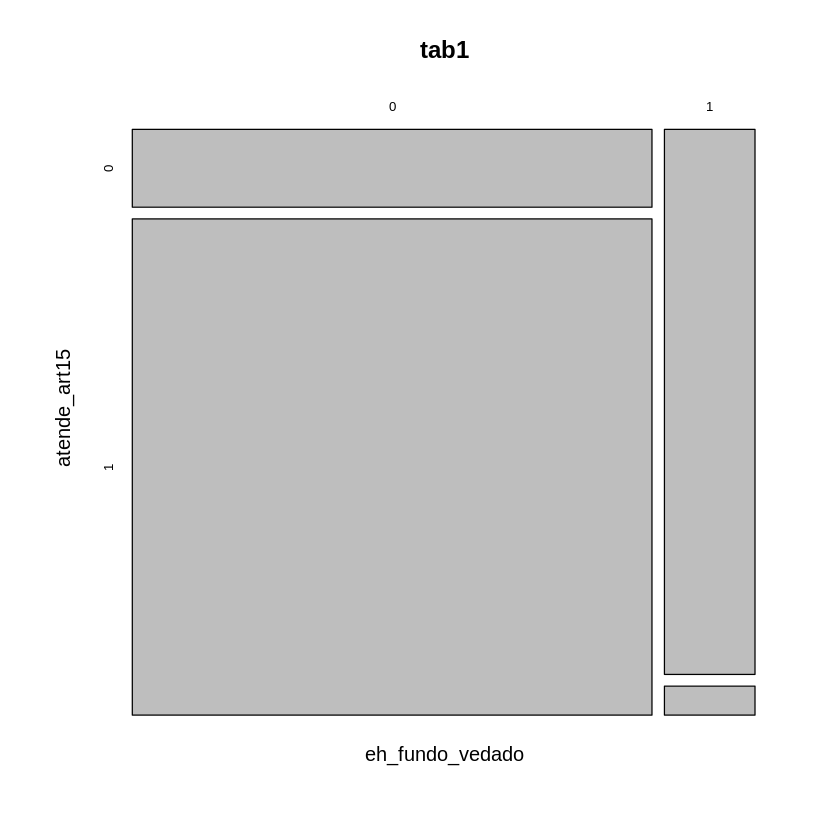

In [0]:
mosaicplot(tab1)

**Ponto 2** - Uma outra questão que pode ser interessante é saber se os fundos vedados (`eh_vedado`) ou os fundos que violem o art. 15 da Resolução 3922/10 (`atende_art15`) guardam alguma relação com o enquadramento dos mesmos (`enquad_sprev_pad`) 

**Ponto 3** - Também pode ser interessante saber se a proporção de RPPS no total de quotistas do fundo pode ter relação com fundos vedados ou fundos que não atendam ao art. 15 da Resolução 3922/10.

**Ponto 4** - Será que os fundos vedados ou que violem o art. 14 tem relação com administradores e gestores?

Nota: aqui temos que ter cuidado porque os administradores e gestores dos fundos podem ter mudado desque que o fundo tenha começado a dar problema.

**Ponto 5** - A lista de fundos investigados tem relação com os fundos vedados?

**Ponto 6** - Será que o tipo de fundo tem relação com ele ser vedado ou não atender ao art. 15 ou, ainda, está na lista de suspeitos?

**Ponto 7** - Será que a proporção de RPPS no total de quotistas pode ter relação com fundos problemáticos? É razoável imaginar que alguns fundos de investimentos de baixa qualidade possa ser prepardos para serem oferecidos a RPPS...

In [0]:
summary(relacao_fundos$NR_COTST)
summary(relacao_fundos$qtd_rpps_investindo)
summary(relacao_fundos$prop_rpps_cotista)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0      57     441   16811    4048  984773     174 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    8.00   48.41   26.00 1408.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00    0.17    2.61     Inf   79.28     Inf     174 

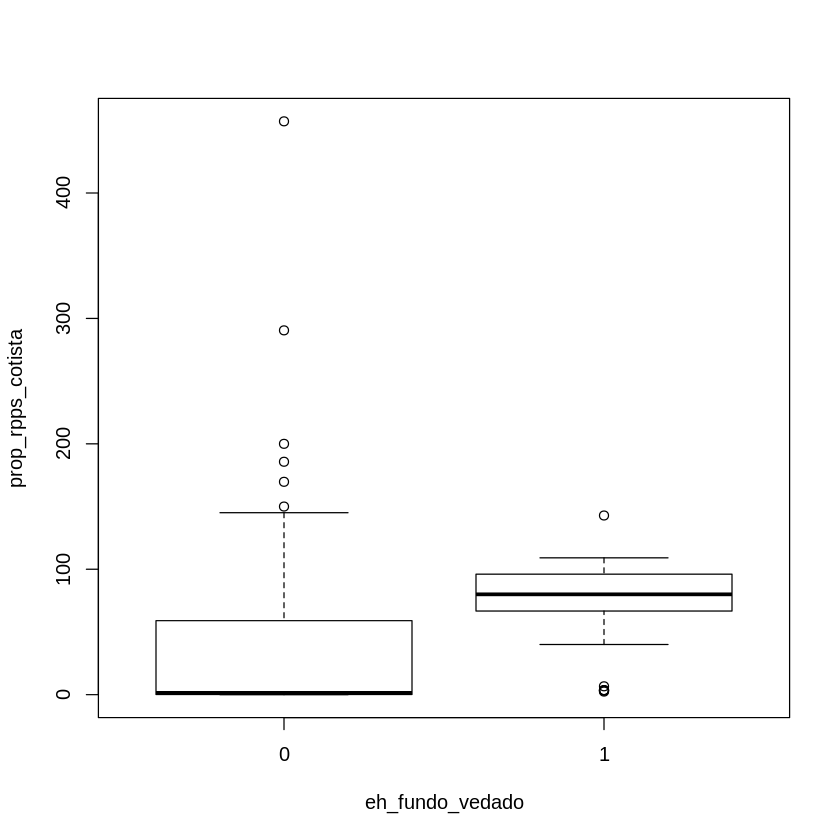

In [0]:
relacao_fundos <- relacao_fundos %>%
                    mutate(prop_rpps_cotista = round(qtd_rpps_investindo / NR_COTST * 100, 2))

boxplot(prop_rpps_cotista ~ eh_fundo_vedado, subset(relacao_fundos, is.finite(prop_rpps_cotista)))

### **Outras análises exploratórias...**

In [0]:
# Relação entre as variáveis- Fundos Estruturados 
with(relacao_fundos,
      table(enquad_sprev_pad, TP_FUNDO))

                TP_FUNDO
enquad_sprev_pad F.I.I. FACFIF FIDC FIF FIIM FIP
        ART7IB        0      0    0   2    0   0
        ART7IIIA      0      0    0   0    0   0
        ART7IVA       0     19    0  24    0   0
        ART7IVB       0      0    0   0    2   0
        ART7VIIA      0      0   34   0    0   0
        ART7VIIB      0      1    0   3    0   0
        ART8IA        0      0    0   1    0   0
        ART8IB        0      0    0   0    3   0
        ART8IIA       0      0    0   0    0   0
        ART8IIB       0      0    0   0    1   0
        ART8III       0      1    0   7    0   0
        ART8IVA       0      0    0   0    0  41
        ART8IVB      42      0    0   0    0   1
        ART9AII       0      0    0   0    1   0
        ART9AIII      0      0    0   0    0   0

In [0]:
# Relação entreas variáveis
with(relacao_fundos,
      table(enquad_sprev_pad, CLASSE))

                CLASSE
enquad_sprev_pad Fundo de Ações Fundo de Renda Fixa Fundo Multimercado
        ART7IB                0                  84                  0
        ART7IIIA              0                  12                  0
        ART7IVA               0                 135                  1
        ART7IVB               0                   0                  0
        ART7VIIA              0                   0                  0
        ART7VIIB              0                  28                  0
        ART8IA               20                   0                  0
        ART8IB                1                   0                  0
        ART8IIA             129                   0                  0
        ART8IIB               1                   0                  0
        ART8III               0                   0                 57
        ART8IVA               0                   0                  0
        ART8IVB               0                   0   

<br>
<br>

---

# **PARTE III - CÁLCULO DA RENTABILIDADE DA CARTEIRA DE FUNDOS DE INVESTIMENTOS**

---



Nesta parte do documento, nosso objetivo é estruturar uma metodologia para calcular a rentabilidade de uma carteira de fundos de investimentos de um RPPS.

<br>
<br>

---

# **PARTE III - ANÁLISE FUNDOS DE INVESTIMENTOS DE RPPS DO RJ**

---

<br>

Vamos agora restringir a base de dados para examinar apenas os registros relativos a RPPS do Estado do Rio de Janeiro.

In [0]:
dair_fundos_rj <- dair_fundos %>%
                    filter(uf == "RJ")

# criar uma lista contendo os rpps de um ente

In [0]:
fundos_representacao_sprev_rj <- c(12845801000137, # 
                                   13344834000166,
                                   13594673000169,
                                   12845801000137,
                                   14655180000154,
                                   18373362000193,
                                   15798354000109)


**Quais RPPS possuem recursos aplicados nos fundos elencados acima?**

In [0]:
entes_fundos_ruins <- dair_fundos_rj %>%
                          filter(ident_ativo %in% fundos_representacao_sprev_rj) %>%
                          distinct(ident_ativo, nm_ativo, ente, tipo_ativo, ) %>%
                          arrange(ident_ativo)

In [0]:
entes_fundos_ruins

ident_ativo,nm_ativo,ente,tipo_ativo
<chr>,<chr>,<chr>,<chr>
12845801000137,TOWER BRIDGE FI RF IMAB 5,Japeri,"ETF - Renda Fixa ""Referenciado"" - Art. 7º, III, b"
12845801000137,TOWER BRIDGE RF FI IMA-B 5,Japeri,"FI Renda Fixa - Geral - Art. 7º, IV, a"
12845801000137,TOWER BRIDGE IMA-B 5 FI RENDA FIXA,Queimados,"FI Renda Fixa ""Referenciado"" - Art. 7º, III, a"
12845801000137,TOWER BRIDGE IMA-B 5 FI RENDA FIXA,Queimados,"FI Renda Fixa - Geral - Art. 7º, IV, a"
13344834000166,INCENTIVO FI em DC MULTISETORIAL II,Japeri,"FI em Direitos Creditórios - Cota Sênior - Art. 7º, VII, a"
13594673000169,TMJ IMA B FI RF,Japeri,"FI Renda Fixa - Geral - Art. 7º, IV, a"
13594673000169,TMJ IMA B FI RF,Japeri,"ETF - Renda Fixa ""Referenciado"" - Art. 7º, III, b"
14655180000154,FI MULTIMERCADO SCULPTOR CRÉDITO PRIVADO,Belford Roxo,"FI Multimercado - Aberto - Art. 8º, III"
15798354000109,FIP LSH MULTIESTRATÉGIA,Iguaba Grande,"FI em Participações - Art. 8º, IV, a"
